In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import datetime as dt
from theano import shared
from functools import reduce
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from pyts.image import MarkovTransitionField

from keras.layers import Input, Dense, LeakyReLU, Dropout
from keras.models import Model, Sequential
from scipy import stats


Using TensorFlow backend.
/Users/suchethasharma/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/suchethasharma/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/suchethasharma/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/suchethash

In [1]:
class CPET_Var:
    """Creates a class for Variance Analysis with CPET self.data
    Input:
        contains the path and files for the data, these should be changed if using on a different machine
    Methods:
        pca            = plots the first principal component scores for each phase of exercise testing, require the input
                         of the variables for principal components (vars) and the exercise levels
        variance       = produces box plots showing distributions of the first principal component scores for 
                         each exercise level
        classificaiton = runs logistic regression to classify the different CPETs as either heart failure or metobolic
                         syndrome."""
    
    
    def __init__(self):
        self.data =list()
        self.demographics = list()
        for i in range(30):
            if i < 15:
                path = "/Users/suchethasharma/Documents/CPET/HF/"
            else:
                path = "/Users/suchethasharma/Documents/CPET/MetSyn/"
            if i < 9:
                sheet = "Subject0"+str(i+1)+"_BxB"
            else:
                sheet = "Subject"+str(i+1)+"_BxB"
            file = sheet+".xlsx"
            
            #print(file)
            #print(pd.ExcelFile(path+file).sheet_names)
            
            df = pd.read_excel(path+file, sheet_name = sheet)
            demographics = pd.read_excel(path+file, sheet_name = "Demographics", index_col=0, index=False).T.reset_index()
            demographics = demographics.rename({'index':'Gender:'}, axis=1)
            demographics.columns = demographics.columns.str[:-1]
            self.demographics.append(demographics.to_dict('records')[0])
                        
            # Create new column names to remove the bad characters in the excel sheets
            df.columns = ['Time', 'METS', 'HR', 'VO2', 'VO2/kg', 'VCO2', 'RER', 'VE', 'VE/VO2','VE/VCO2', 'RR', 'VTex', 'VTin', 'Speed', 'Elev']
            self.data.append(df.drop(df.index[[0]])) # drop the row below column names

            # Get the indices for each of the stages of the test
            restidx = self.data[i].loc[self.data[i]["METS"] == "Rest"].index 
            recoveryidx = self.data[i].loc[self.data[i]["METS"] == "Recovery"].index 
            warmupidx = self.data[i].loc[self.data[i]["METS"] == "Warmup"].index 
    
            # Create a new categorical variable Rest = 1, not rest =0
            self.data[i]["Rest"] = np.zeros(len(self.data[i]), dtype = int)
            testidx = self.data[i].loc[self.data[i]["METS"] == "Test"].index 
            # Create a new categorical variable Test = 1, not test =0
            self.data[i].loc[restidx[0]+1:testidx[0]+1,"Rest"] =1  
            self.data[i]["Test"] = np.zeros(len(self.data[i]), dtype = int)
            self.data[i].loc[testidx[0]+1:recoveryidx[0]+1,"Test"] =1 
            # Create a new categorical variable Recovery = 1, not rest =0
            self.data[i]["Recovery"] = np.zeros(len(self.data[i]), dtype = int)
            self.data[i].loc[recoveryidx[0]+1:,"Recovery"] =1 
                
            # drop the row with rest indicated
            self.data[i].drop(restidx, axis = 0, inplace = True)
        
            # drop the row with test indicated
            self.data[i].drop(testidx, axis = 0, inplace = True)
            
            # drop row with recovery indicated
            self.data[i].drop(recoveryidx, axis = 0, inplace = True)

            #drop row with warmup
            self.data[i].drop(warmupidx, axis = 0, inplace = True)

            # Change strings to float
            self.data[i][['METS', 'HR', 'VO2', 'VO2/kg', 'VCO2', 'VE','RR', 'VTex', 'VTin']]= \
            self.data[i][['METS', 'HR', 'VO2', 'VO2/kg', 'VCO2', 'VE','RR', 'VTex', 'VTin']].astype(np.float)
            # Change strings to int
            self.data[i][['Speed', 'Elev']] = self.data[i][['Speed', 'Elev']].astype(np.int)
            
            # Compute Peak VO2
            peakVO2 = max(self.data[i]['VO2'].dropna())
            peakVO2kg = max(self.data[i]['VO2/kg'].dropna())
            normalVO2 = {'male':{20:48, 30:42.4, 40:37.8, 50:32.6, 60:28.2, 70:24.4},
                         'female':{20:37.6, 30:30.2, 40:26.7, 50:23.4, 60:20, 70:18.3}}
            gender = self.demographics[i]['Gender'].lower()
            age = self.demographics[i]['Age']
            age_group = int(age/10)*10
            height = self.demographics[i]['Height (cm)']
            weight = self.demographics[i]['Weight (kg)']
            if (age_group > 70):
                age_group = 70
            if peakVO2kg < normalVO2[gender][age_group]:
                self.demographics[i]['PeakVO2'] = 'low'
            else :
                self.demographics[i]['PeakVO2'] = 'normal'            
            
            #Hansen numbers
            if (age_group < 30):
                age = 30
            if gender == 'male':
                ideal_weight = 0.79 * height - 60.7
                if height >= ideal_weight:
                     normal_hansen = 0.0337 * height - 0.000165 * age * height - 1.963 + 0.006 * (weight - ideal_weight)
                else:
                    normal_hansen = 0.0337 * height - 0.000165 * age * height - 1.963 + 0.014 * (weight - ideal_weight)
            else:
                ideal_weight = 0.65 * height - 42.8
                normal_hansen = 0.001 * height * (14.783 - 0.11 * age) + 0.006 * (weight - ideal_weight)
            
            if peakVO2 < normal_hansen:
                self.demographics[i]['PeakVO2Hansen'] = 'low'
            else :
                self.demographics[i]['PeakVO2Hansen'] = 'normal' 
                        
        # Plot AT
        _, ax = plt.subplots(10,3, figsize = (21,21), constrained_layout = True)

        for i in range(10):
            for j in range(3):
                c = i*3+j # the index for the patients
                y_axis1 = (self.data[c]['VE']/self.data[c]['VO2'])
                y_axis2 = (self.data[c]['VE']/self.data[c]['VCO2'])
                time = (self.data[c]['Time']).dropna()
                
                index1 = y_axis1[(y_axis1 >= y_axis1.quantile(0.05)) & (y_axis1 <= y_axis1.quantile(0.95))].index
                index2 = y_axis2[(y_axis2 >= y_axis2.quantile(0.05)) & (y_axis2 <= y_axis2.quantile(0.95))].index
                index = index1.intersection(index2)
                time = time[index]
                seconds = pd.to_datetime(time, format=' %M:%S').astype('int64')*1e-9
                y_axis1 = y_axis1[index]
                y_axis2 = y_axis2[index]
                
                # Find AT
                slope1 = np.diff(y_axis1)/np.diff(seconds)
                slope2 = np.diff(y_axis2)/np.diff(seconds)
                gradient1 = np.diff(slope1)
                gradient2 = np.diff(slope2)
                th1 = 0.1
                th2 = 0.001
                at_points = []
                while not at_points:
                    increasing_points = np.where(gradient1>=th1)[0]
                    constant_points = np.where((gradient2<=th2) & (gradient2>=-th2))[0]
                    at_points = np.intersect1d(constant_points, np.concatenate([increasing_points,
                                                                                increasing_points+1,
                                                                                increasing_points-1])).tolist()
                    th1 -= 0.01
                    th2 += 0.001
                at_point = at_points[np.argmin(gradient2[at_points])]
                VO2 = self.data[c]['VO2/kg'].dropna()
                VO2_at = VO2[index].iloc[at_point]
                gender = self.demographics[c]['Gender'].lower()
                age = self.demographics[c]['Age']
                age_group = int(age/10)*10
                if (age_group > 70):
                    age_group = 70
                
                normalVO2_at = {'male':{20:22.0, 30:21.3, 40:20.1, 50:18.2, 60:17.8, 70:16.5},
                                'female':{20:21.7, 30:16.2, 40:16.2, 50:15.0, 60:13.5, 70:12.3}}
                if VO2_at < normalVO2_at[gender][age_group]:
                    self.demographics[c]['VO2_AT'] = 'low'
                else :
                    self.demographics[c]['VO2_AT'] = 'normal' 
                
                peakVO2 = self.demographics[c]['PeakVO2']
                peakVO2Hansen = self.demographics[c]['PeakVO2Hansen']
                BMI = self.demographics[c]['BMI']
                
                if peakVO2 == 'normal':
                    if BMI > 30:
                        self.demographics[c]['Flowsheet Prediction'] = 'Metabolic Syndrome'
                    else:
                        self.demographics[c]['Flowsheet Prediction'] = 'Normal'
                else:
                    if VO2_at < normalVO2_at[gender][age_group]:
                        self.demographics[c]['Flowsheet Prediction'] = 'HFrEf'
                    elif BMI > 30:
                        self.demographics[c]['Flowsheet Prediction'] = 'Metabolic Syndrome'
                    else:
                        self.demographics[c]['Flowsheet Prediction'] = 'Other/Lung Disease'
                        
                if peakVO2Hansen == 'normal':
                    if BMI > 30:
                        self.demographics[c]['Flowsheet (Hansen) Prediction'] = 'Metabolic Syndrome'
                    else:
                        self.demographics[c]['Flowsheet (Hansen) Prediction'] = 'Normal'
                else:
                    if VO2_at < normalVO2_at[gender][age_group]:
                        self.demographics[c]['Flowsheet (Hansen) Prediction'] = 'HFrEf'
                    elif BMI > 30:
                        self.demographics[c]['Flowsheet (Hansen) Prediction'] = 'Metabolic Syndrome'
                    else:
                        self.demographics[c]['Flowsheet (Hansen) Prediction'] = 'Other/Lung Disease'
                
                # make a plot
                ax[i,j].plot(time, y_axis1, color="red", marker="o", linestyle="None")
                # set x-axis label
                ax[i,j].set_xlabel("Time",fontsize=14)
                ax[i,j].xaxis.set_major_locator(plt.MaxNLocator(10))
                # set y-axis label
                ax[i,j].set_ylabel("VE/VO2",color="red",fontsize=14)

                # twin object for two different y-axis on the sample plot
                ax2=ax[i,j].twinx()
                # make a plot with different y-axis using second axis object
                ax2.plot(time, y_axis2, color="blue", marker="o", linestyle="None")
                ax2.set_ylabel("VE/VCO2",color="blue",fontsize=14)
                ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
                
                print(self.demographics[c])
               
                
        Y = np.concatenate((np.zeros(15, dtype=int), np.ones(15, dtype=int)))
        fs_predicted = np.ones(30, dtype=int)*3
        fs_predicted[pd.DataFrame(self.demographics)['Flowsheet Prediction'] == 'HFrEf'] = 0
        fs_predicted[pd.DataFrame(self.demographics)['Flowsheet Prediction'] == 'Metabolic Syndrome'] = 1
        fs_predicted[pd.DataFrame(self.demographics)['Flowsheet Prediction'] == 'Other/Lung Disease'] = 2
        
        print("Flowsheet Accuracy: ", accuracy_score(Y, fs_predicted))
        print (classification_report(Y, fs_predicted)) 
        
        fs_predicted = np.ones(30, dtype=int)*3
        fs_predicted[pd.DataFrame(self.demographics)['Flowsheet (Hansen) Prediction'] == 'HFrEf'] = 0
        fs_predicted[pd.DataFrame(self.demographics)['Flowsheet (Hansen) Prediction'] == 'Metabolic Syndrome'] = 1
        fs_predicted[pd.DataFrame(self.demographics)['Flowsheet (Hansen) Prediction'] == 'Other/Lung Disease'] = 2
        
        print("Flowsheet (Hansen) Accuracy: ", accuracy_score(Y, fs_predicted))
        print (classification_report(Y, fs_predicted)) 
        
        plt.savefig('AT_plots.png')

    def pca(self, vars, exercise_levels, reduced_dim):
        # set the variables for pca
        self.vars = vars
        
        # The exercise levels
        self.exercise_levels =  exercise_levels
        # colors for plotting pcs
        colors = ['blue', 'green', 'red']

        # Plot pca
        _, ax = plt.subplots(10,3, sharex = True, sharey = True, figsize = (21,21), constrained_layout = True)

        # the list of observational arrays in the pca transformed space
        self.pca_data = list()

        for i in range(10):
            for j in range(3):
                c = i*3+j # the index for the patients
                # Remove the nan's 
                df = self.data[c].dropna(axis=0)
                # Standardize the variables, to mean 0 variance 1
                mean = df[self.vars].mean()
                std = df[self.vars].std()
                X = np.array((df[self.vars] - mean) / std)
                # Project data onto the principal components
                pca = PCA(n_components = reduced_dim)
                pca_pcat = pca.fit_transform(X)
                self.pca_data.append(pca_pcat)
                for effort, color in zip(self.exercise_levels, colors):
                    idx = df[effort] == 1
                    ax[i,j].scatter(pca_pcat[idx,0],pca_pcat[idx,1],c=color)
                    if c < 15:
                        ax[i,j].set_title("PCA HF Patient "+ str(c+1) ,fontsize=20)
                    else:
                        ax[i,j].set_title("PCA Metabolic Syndrome Patient "+ str(c-14) ,fontsize=20)
                    ax[i,j].legend(exercise_levels)
        plt.show()
        return(self.pca_data)

    def autoencoder(self, vars, exercise_levels, reduced_dim):
        # set the variables for ae
        self.vars = vars
        
        # The exercise levels
        self.exercise_levels =  exercise_levels

        # the list of observational arrays in the ae transformed space
        self.ae_data = list()

        for i in range(10):
            for j in range(3):
                c = i*3+j # the index for the patients
                # Remove the nan's 
                df = self.data[c].dropna(axis=0)
                # Standardize the variables, to mean 0 variance 1
                mean = df[self.vars].mean()
                std = df[self.vars].std()
                X = np.array((df[self.vars] - mean) / std)
                
                # this is our input placeholder
                Xin = Input(shape=(X.shape[1],))
                encoded = Dense(reduced_dim, activation='relu')(Xin)
                decoded = Dense(X.shape[1], activation=None)(encoded)

                autoencoder = Model(Xin, decoded)
                autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
                autoencoder.fit(X,X,
                                epochs=500,
                                batch_size=10,
                                shuffle=True,
                                verbose=0)
                
                encoder = Model(Xin, encoded)
                autoencoded_X = autoencoder.predict(X)
                self.ae_data.append(autoencoded_X)
        return(self.ae_data)


   
    def variance(self, reduced_data):
        self.reduced_data = reduced_data
        # Plot boxplots of pca transformed observations
        _, ax = plt.subplots(10,3, sharex = True, sharey = True, figsize = (21,21), constrained_layout = True)
        for i in range(10):
            for j in range(3):
                c = i*3+j # the index for the patients
                # Remove the nan's 
                df = self.data[c].dropna(axis=0)
                # put the data into a list for plotting
                plot_list = list()
                for effort in self.exercise_levels:
                    idx = df[effort] == 1
                    plot_list.append(self.reduced_data[c][idx,0])
                ax[i,j].boxplot(plot_list)
                if c < 15:
                    ax[i,j].set_title("HF Patient "+ str(c+1) ,fontsize=20)
                else:
                    ax[i,j].set_title("Metabolic Syndrome Patient "+ str(c-14) ,fontsize=20)
        plt.show()

    def classification(self, reduced_data):
        self.reduced_data = reduced_data
        # variables for classifcation
        # data array
        X = np.zeros((30,6))
        for c in range(30):
            # Remove the nan's 
            df = self.data[c].dropna(axis=0)
            for j,effort in enumerate(self.exercise_levels):
                idx = df[effort] == 1
                X[c,j] = np.median(self.reduced_data[c][idx,0])
                Q1 = np.percentile(self.reduced_data[c][idx,0], 25)
                Q3 = np.percentile(self.reduced_data[c][idx,0], 75)
                X[c,j+3] = Q3-Q1
        Y = np.concatenate((np.zeros(15, dtype=int), np.ones(15, dtype=int)))
        cv_predicted = cross_val_predict(linear_model.LogisticRegression(solver = 'lbfgs'), X, Y, cv=3)
        print("Accuracy: ", accuracy_score(Y, cv_predicted))
        print (classification_report(Y, cv_predicted)) 

{'Gender': 'Female', 'Age': 66, 'Height (cm)': 161, 'Weight (kg)': 104.7, 'BMI': 40, 'Condition': 'HFrEF', 'PeakVO2': 'low', 'PeakVO2Hansen': 'low', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'HFrEf'}
{'Gender': 'Male', 'Age': 79, 'Height (cm)': 176, 'Weight (kg)': 85.4, 'BMI': 28, 'Condition': 'HFrEf', 'PeakVO2': 'low', 'PeakVO2Hansen': 'normal', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'Normal'}
{'Gender': 'Male', 'Age': 60, 'Height (cm)': 188, 'Weight (kg)': 132.6, 'BMI': 38, 'Condition': 'HFrEf', 'PeakVO2': 'low', 'PeakVO2Hansen': 'low', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'HFrEf'}
{'Gender': 'Male', 'Age': 57, 'Height (cm)': 180, 'Weight (kg)': 118.9, 'BMI': 37, 'Condition': 'HFrEf', 'PeakVO2': 'low', 'PeakVO2Hansen': 'low', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'HFrEf'}
{'Gender': 'Male', 'Age': 80, 'Height (

/Users/suchethasharma/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


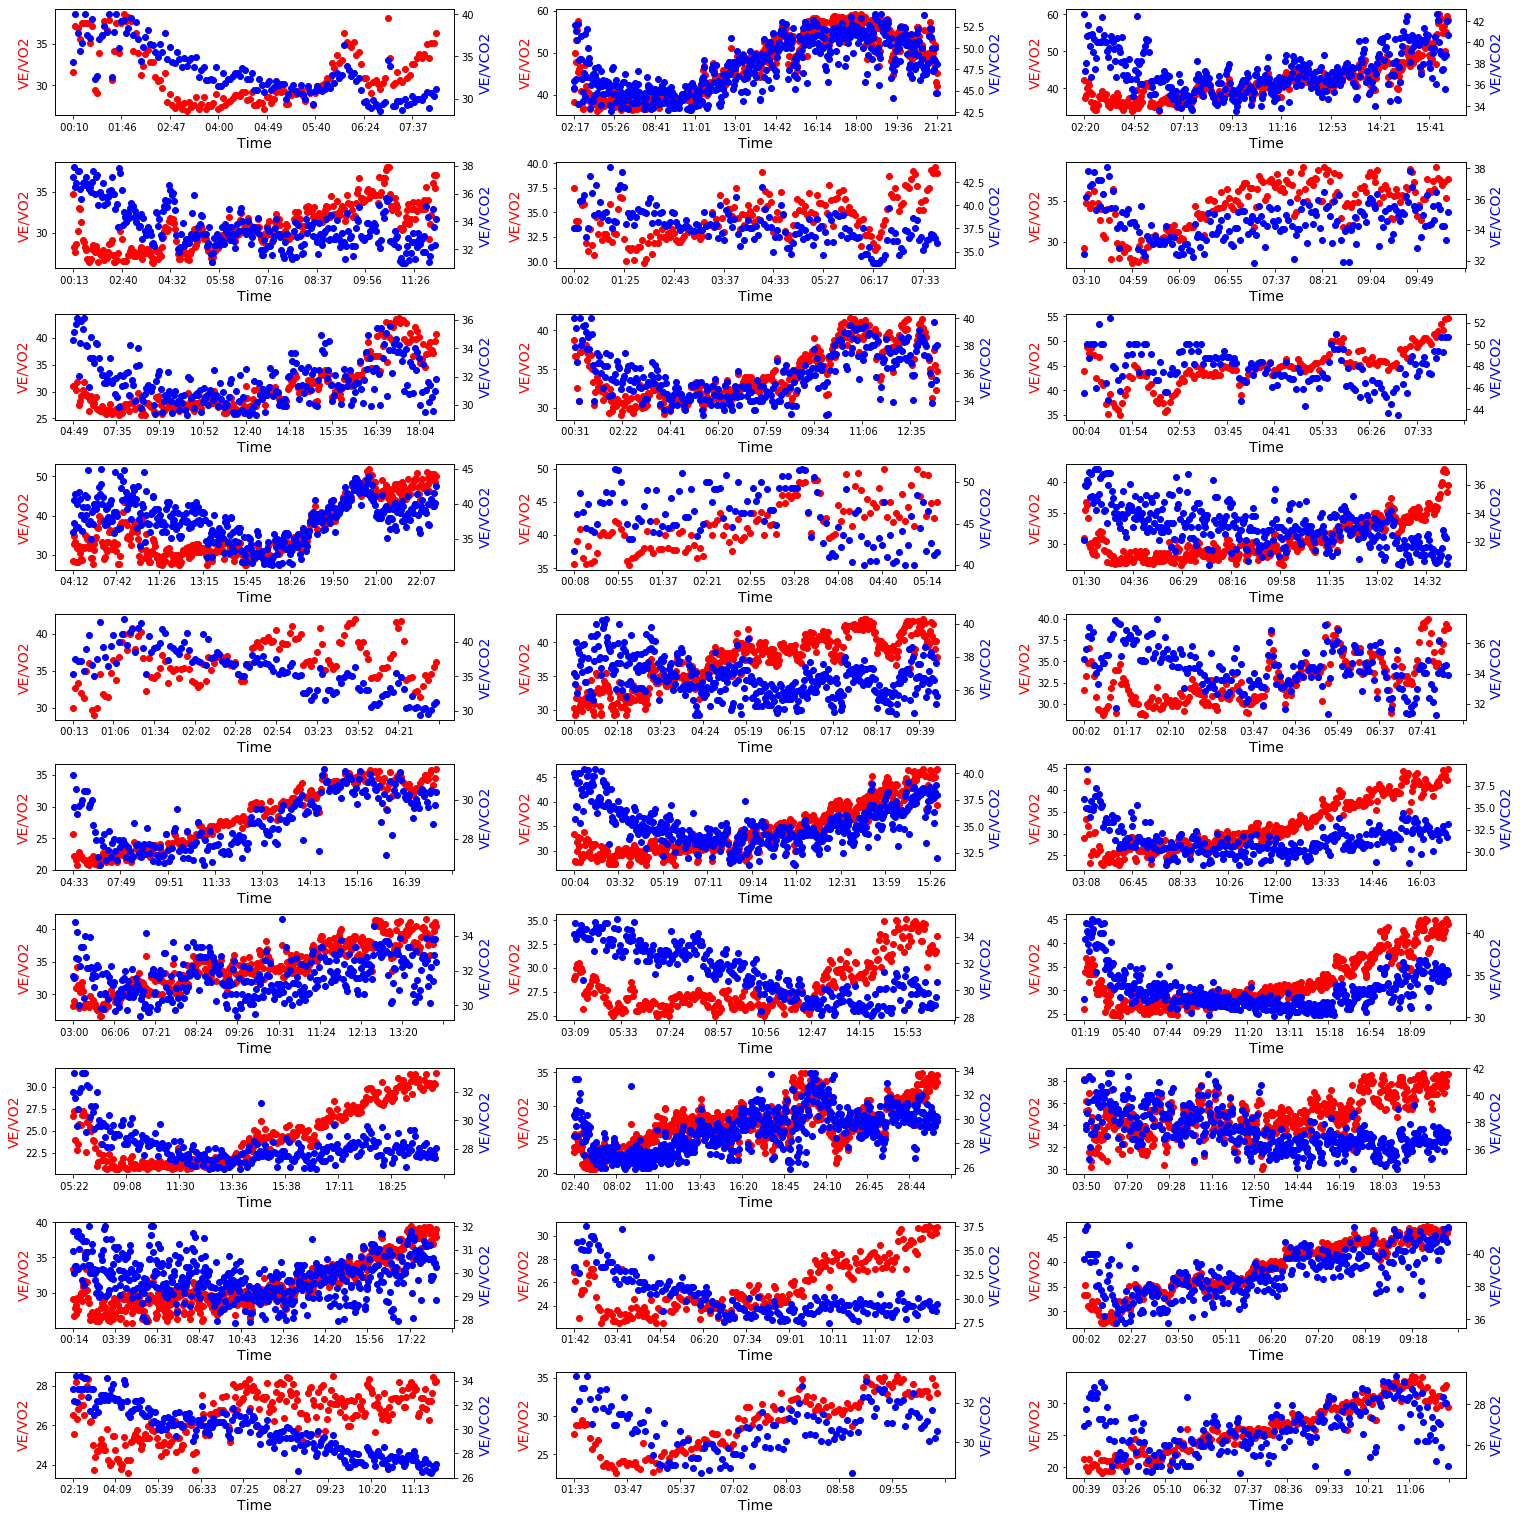

In [3]:
uva_cpet = CPET_Var()

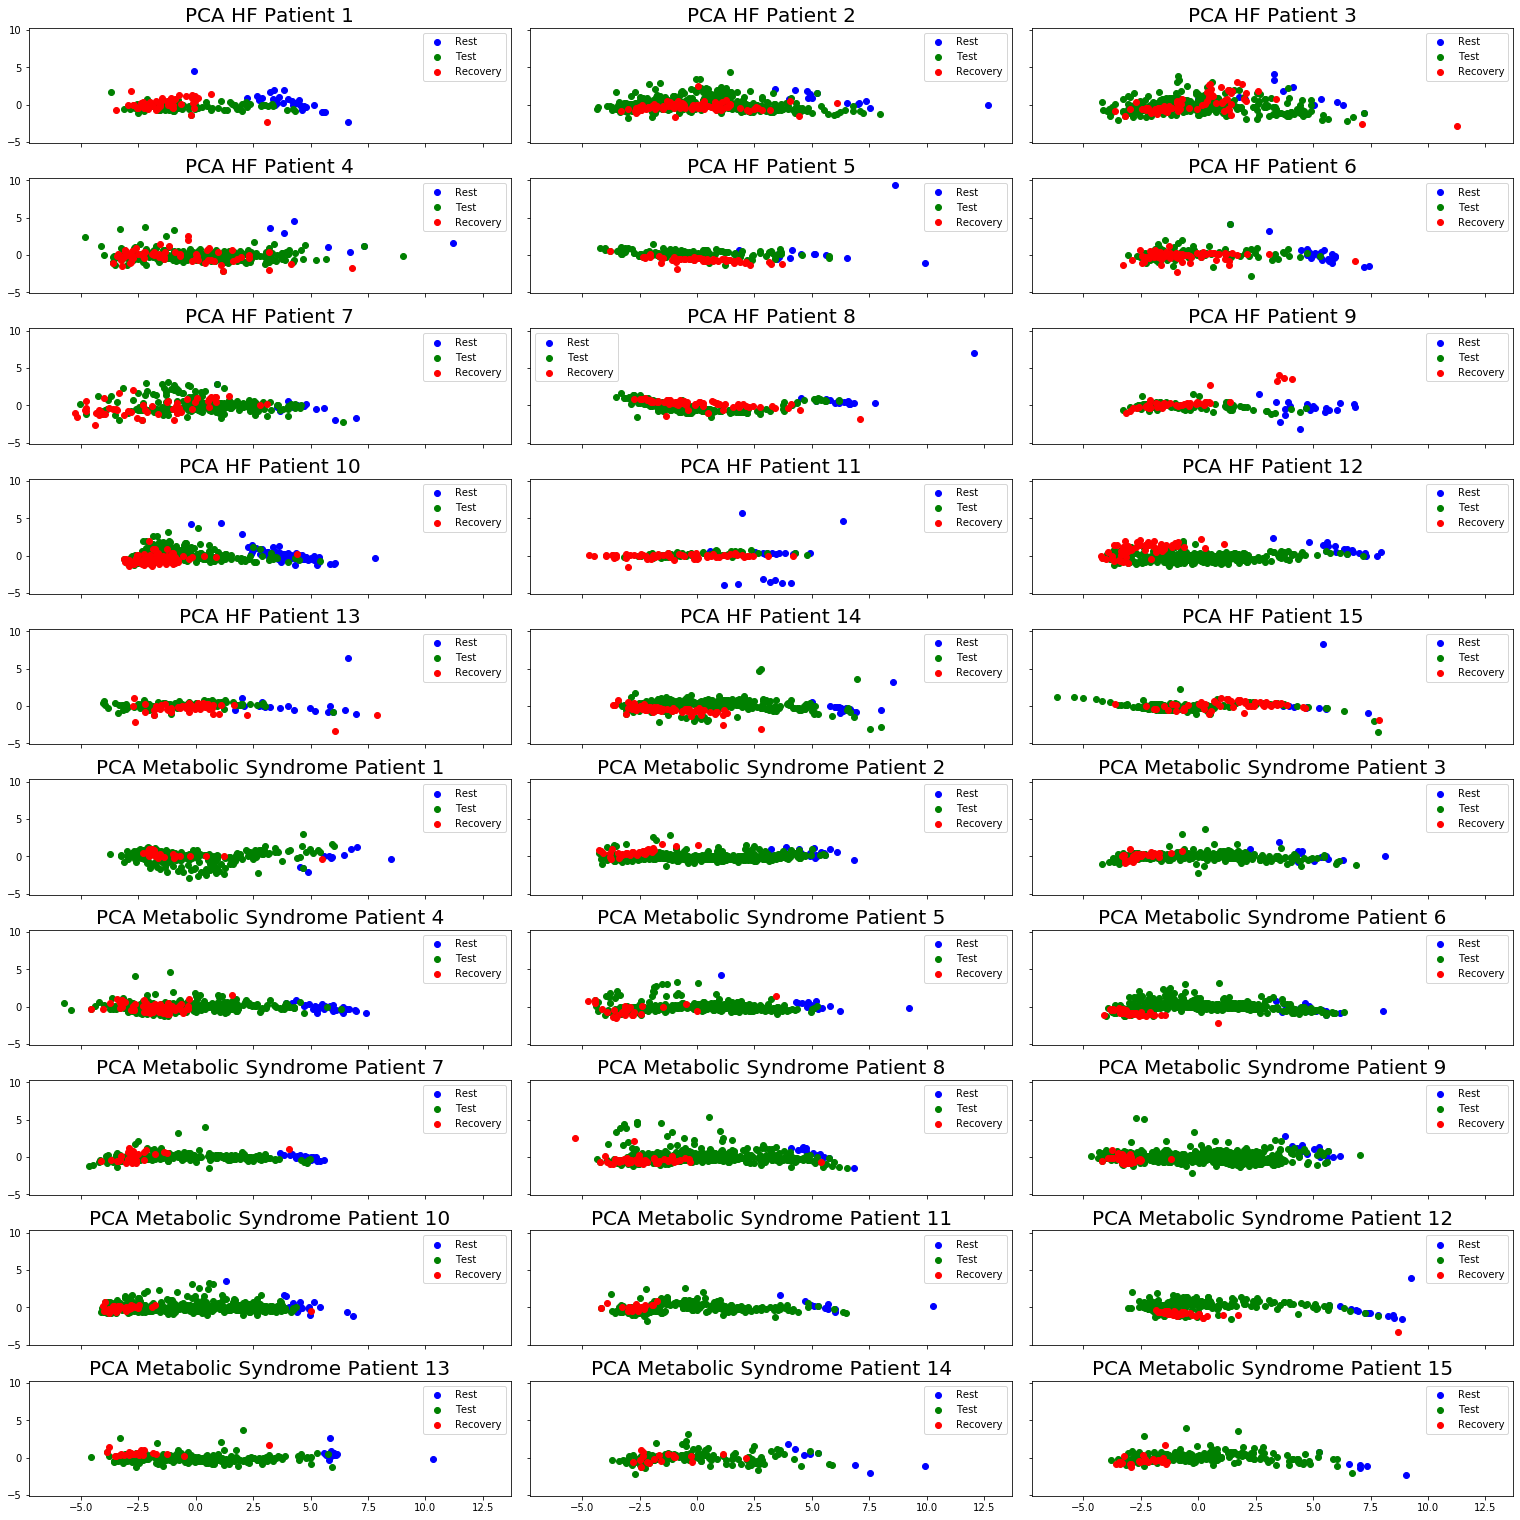

In [5]:
# Run the class to get the pca plots
vars= ['VO2', 'VCO2', 'VE', 'VTex', 'VTin', 'METS']
exercise_levels= ["Rest", "Test", "Recovery"]
pca_data = uva_cpet.pca(vars, exercise_levels, 3);

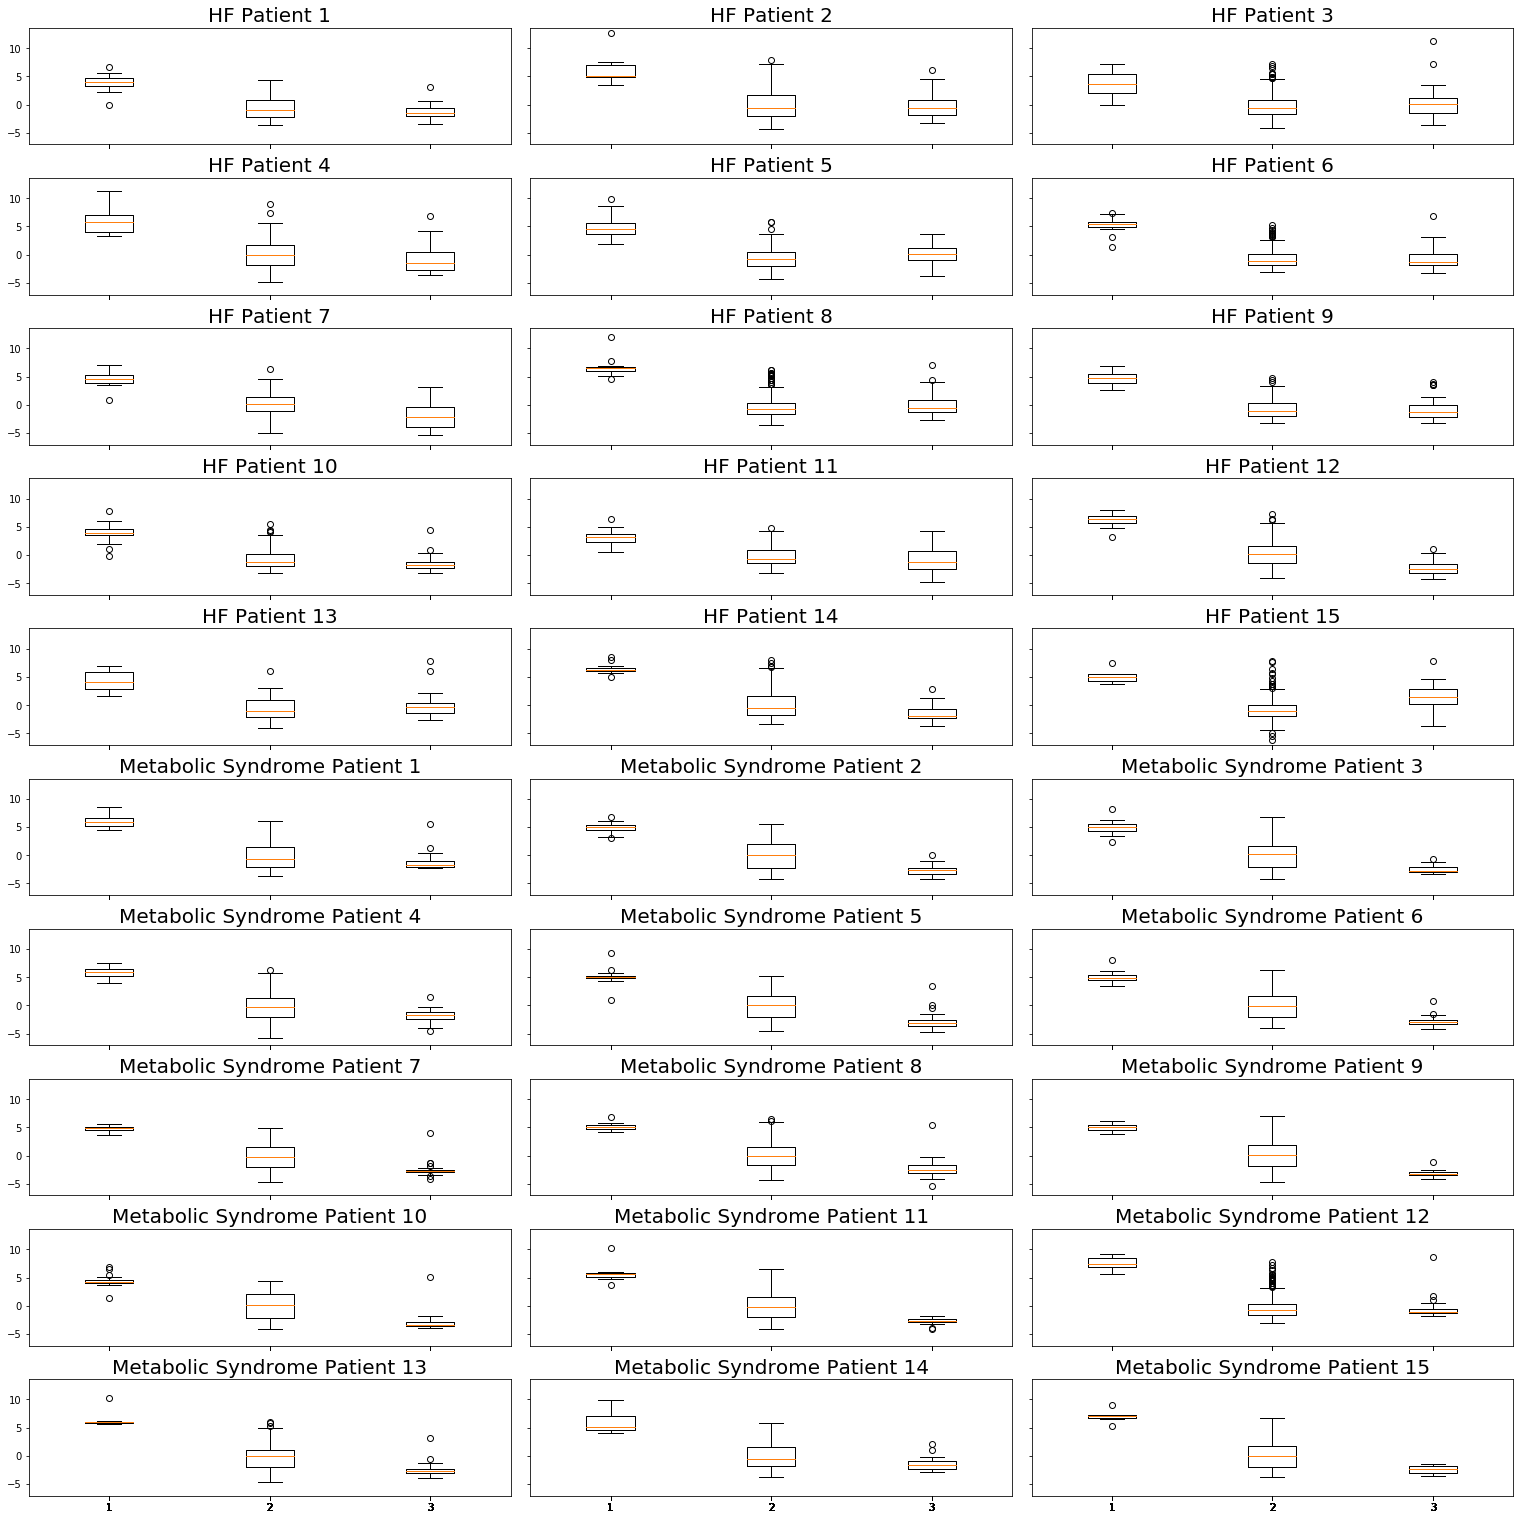

In [6]:
uva_cpet.variance(pca_data)

In [7]:
uva_cpet.classification(pca_data)

Accuracy:  0.9
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.88      0.93      0.90        15

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



{'Gender': 'Female', 'Age': 66, 'Height (cm)': 161, 'Weight (kg)': 104.7, 'BMI': 40, 'Condition': 'HFrEF', 'PeakVO2': 'low', 'PeakVO2Hansen': 'low', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'HFrEf'}
{'Gender': 'Male', 'Age': 79, 'Height (cm)': 176, 'Weight (kg)': 85.4, 'BMI': 28, 'Condition': 'HFrEf', 'PeakVO2': 'low', 'PeakVO2Hansen': 'normal', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'Normal'}
{'Gender': 'Male', 'Age': 60, 'Height (cm)': 188, 'Weight (kg)': 132.6, 'BMI': 38, 'Condition': 'HFrEf', 'PeakVO2': 'low', 'PeakVO2Hansen': 'low', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'HFrEf'}
{'Gender': 'Male', 'Age': 57, 'Height (cm)': 180, 'Weight (kg)': 118.9, 'BMI': 37, 'Condition': 'HFrEf', 'PeakVO2': 'low', 'PeakVO2Hansen': 'low', 'VO2_AT': 'low', 'Flowsheet Prediction': 'HFrEf', 'Flowsheet (Hansen) Prediction': 'HFrEf'}
{'Gender': 'Male', 'Age': 80, 'Height (

/Users/suchethasharma/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


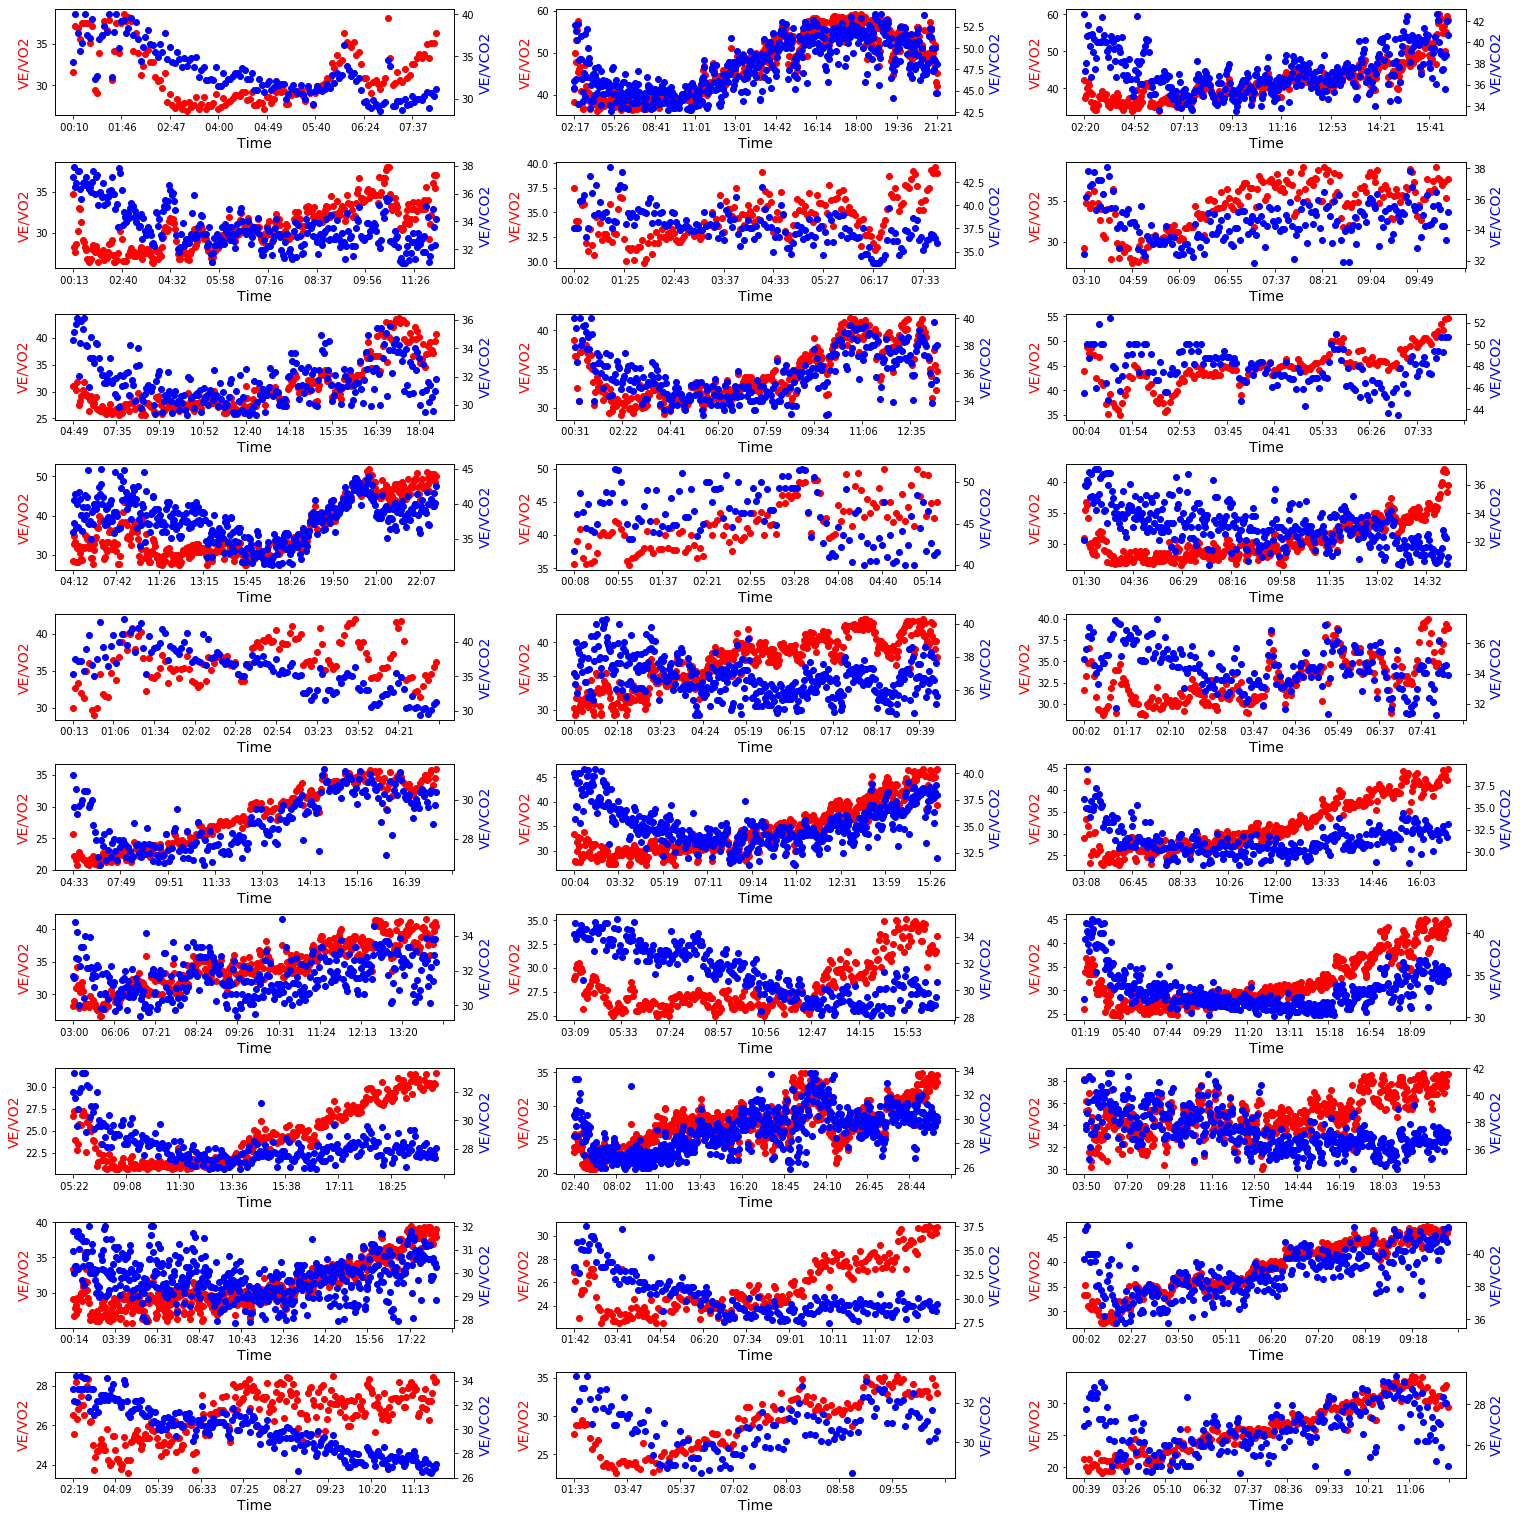

In [8]:
# Run the class to get the ae data

uva_cpet = CPET_Var()
vars= ['VO2', 'VCO2', 'VE', 'VTex', 'VTin', 'METS']
exercise_levels= ["Rest", "Test", "Recovery"]
ae_data = uva_cpet.autoencoder(vars, exercise_levels, 3);

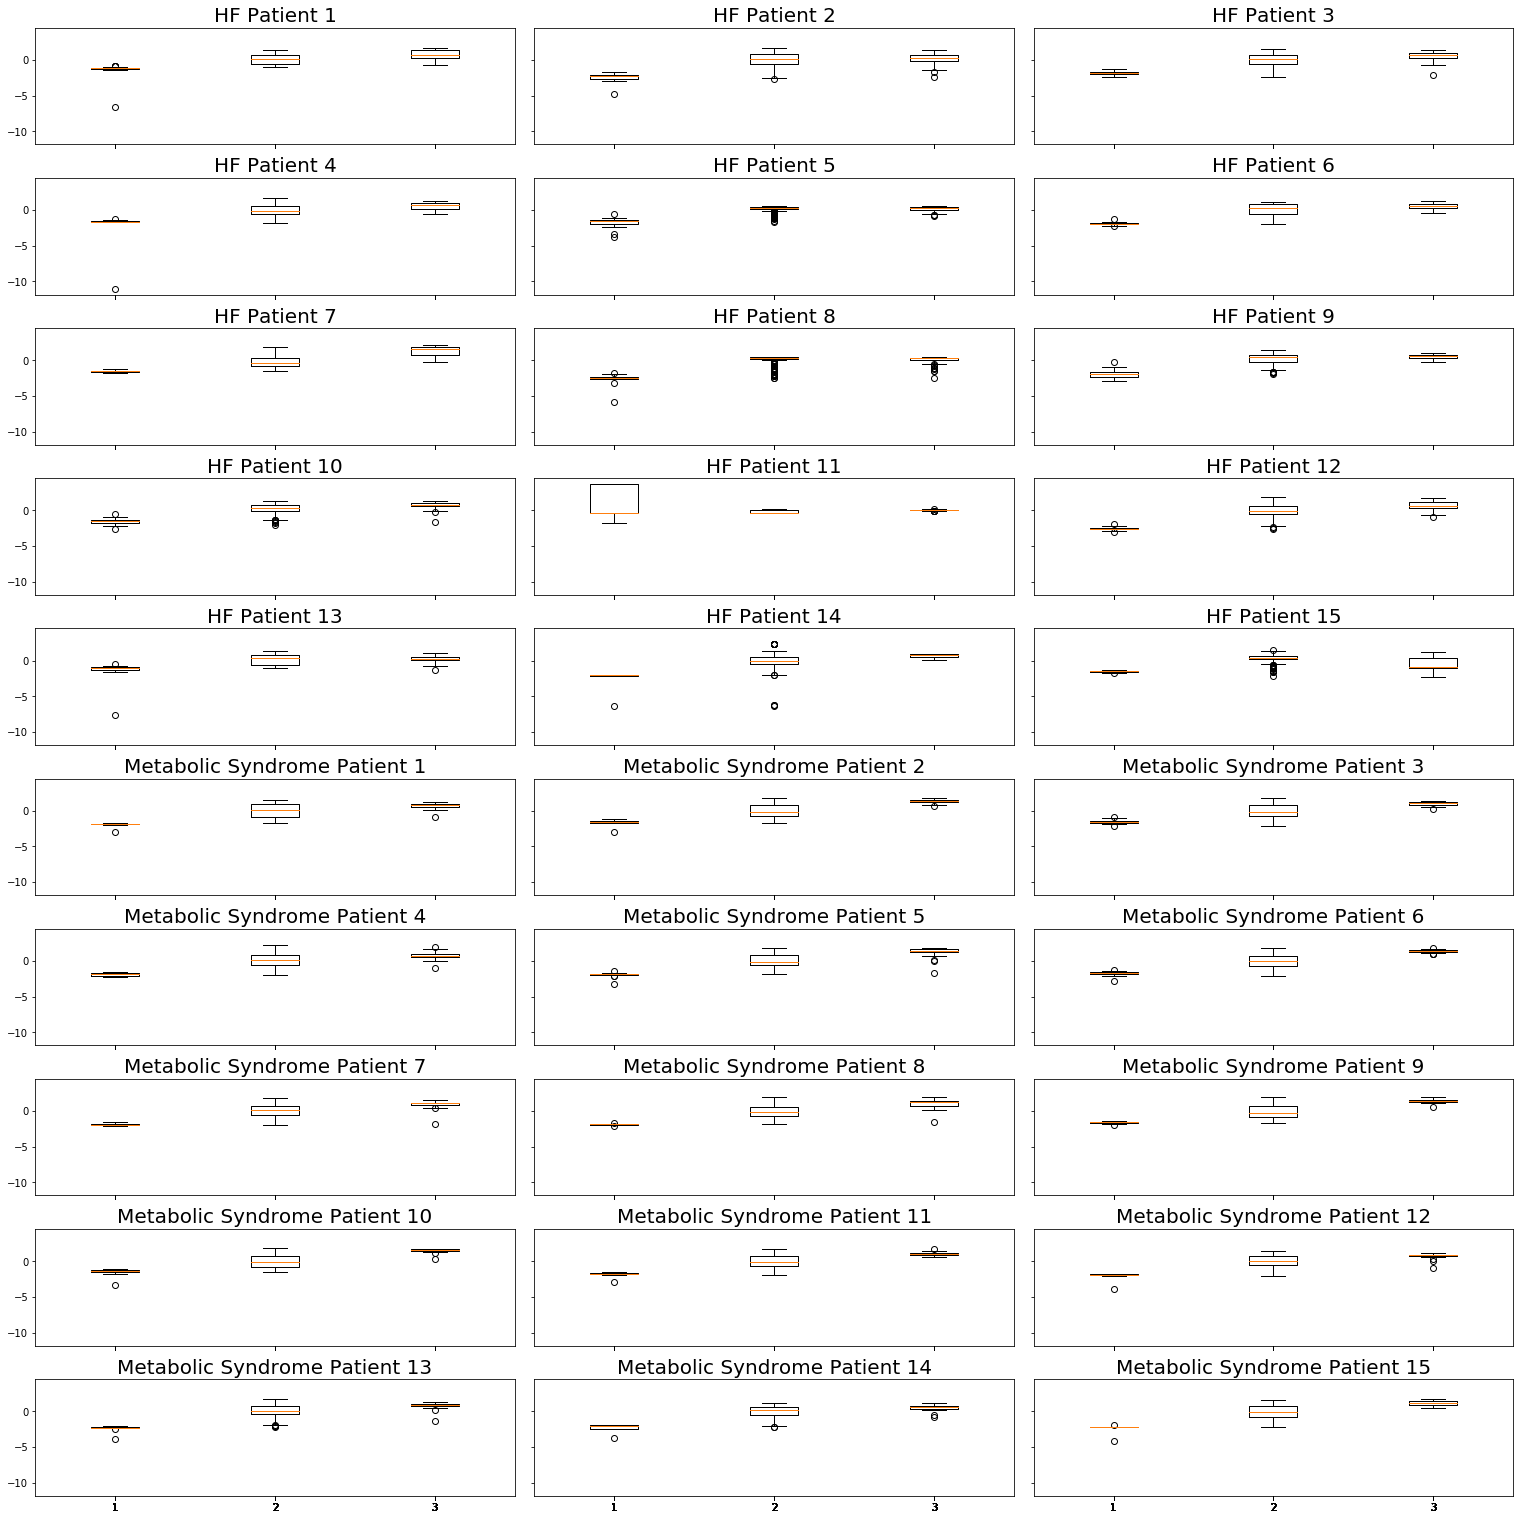

In [9]:
uva_cpet.variance(ae_data)

In [10]:
uva_cpet.classification(ae_data)

Accuracy:  0.9333333333333333
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.93      0.93      0.93        15

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

